In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import polatory
from scipy import interpolate
from scipy import spatial
import seaborn as sns

from utils import (config_rcparams,
                   set_axes_equal,
                   set_3d_params,
                   estimate_normals,
                   orient_normals)

In [2]:
config_rcparams()

In [3]:
%config InlineBackend.figure_format = 'retina'

# Toy example: Gaussian-pattern compliance-zone boundary

In [4]:
def f(x, y, A=1, x0=0, y0=0, theta_x=1, theta_y=1):
    """2D Gaussian function.

    Parameters
    ----------
    x : float of numpy.ndarray
        Spatial coordinate(s), x-direction
    y : float of numpy.ndarray
        Spatial coordinate(s), y-direction
    A : float, optional
        Amplitude    
    x0 : float, optional
        Center of the blob, x-direction
    y0 : float, optional
        Center of the blob, y-direction
    theta_x : float, optional
        Spread of the blob, x-direction
    theta_y : float, optional
        Spread of the blob, y-direction

    Returns
    -------
    float or numpy.ndarray
        Value(s) of the Guassian function, z-direction
    """
    return A * np.exp(
        - (x - x0) ** 2 / (2 * theta_x ** 2)
        - (y - y0) ** 2 / (2 * theta_y ** 2))

In [5]:
# generate surface points of the compliance-zone boundary
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
X, Y = np.meshgrid(x, y)
Z = f(X, Y, A=2, theta_x=0.3, theta_y=0.3)

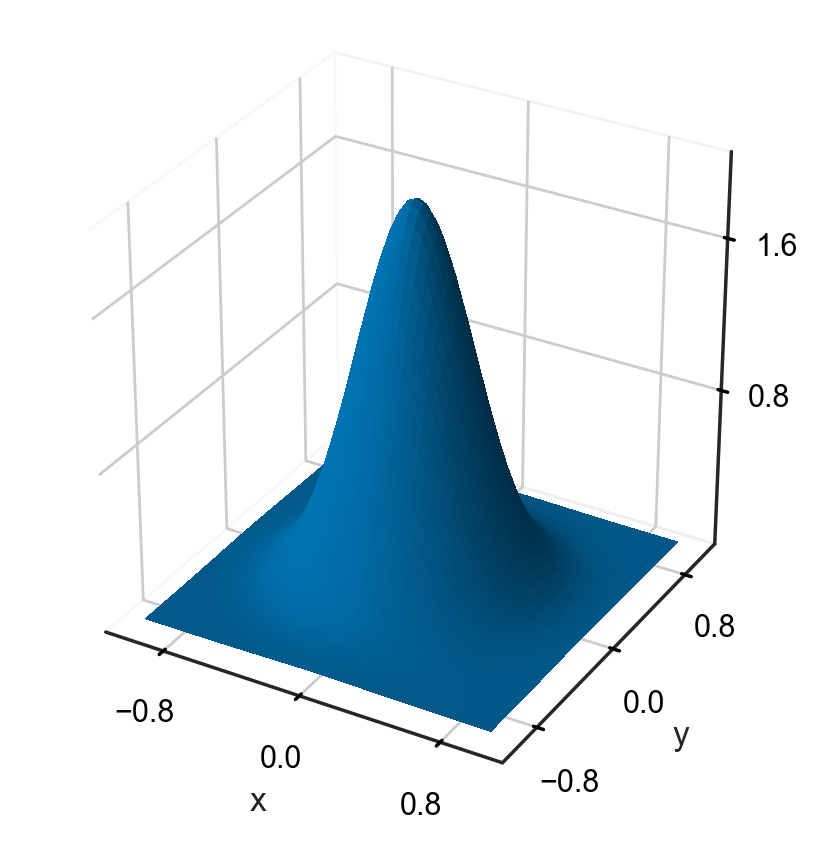

In [6]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax = set_3d_params(ax)
surf = ax.plot_surface(X, Y, Z, lw=0, cstride=1, rstride=1, antialiased=False)

## Normal estimation at each evaluation point

In [7]:
# create the point cloud and generate a unit normal at each point
points = np.c_[X.ravel(), Y.ravel(), Z.ravel()]
normals = estimate_normals(points, k=20)
normals = orient_normals(points, normals, k=20)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


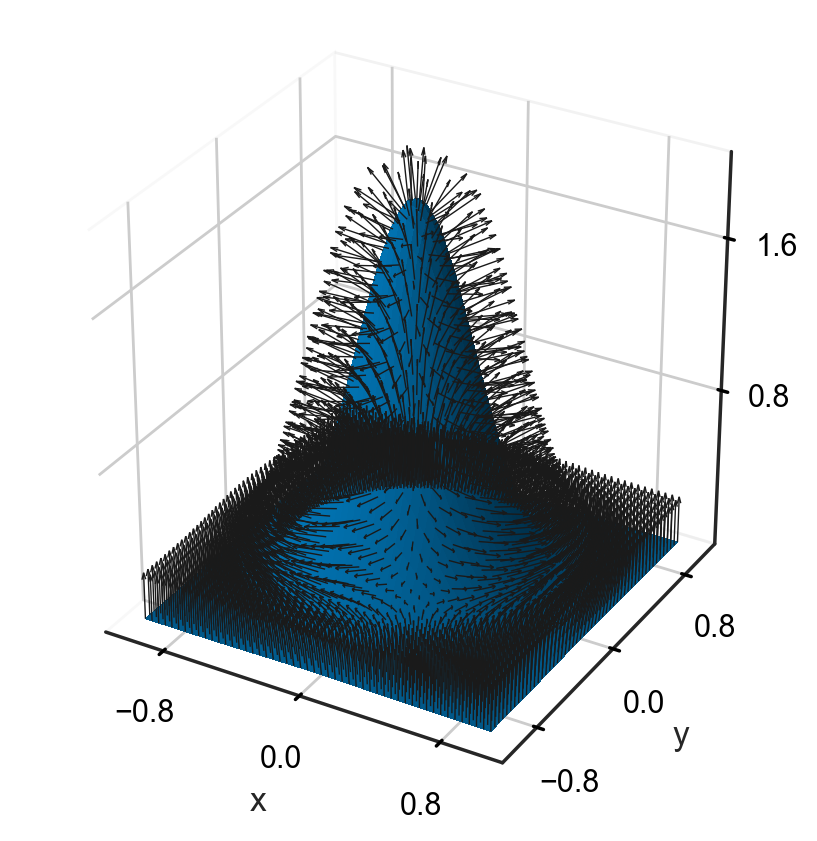

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax = set_3d_params(ax)
surf = ax.plot_surface(X, Y, Z, lw=0, cstride=1, rstride=1, antialiased=False)
q = ax.quiver(*points.T, *normals.T, color='k',
              lw=0.5, length=0.25, arrow_length_ratio=0.15)

## How to check whether a point is within the compliance-zone boundaries?

### Radial basis function (RBF) interpolation

The first method in this notebook interpolates the points on the surface of the compliance-zone boundaries in 3D space by using RBF.

Herein, the [`polatory`](https://github.com/polatory/polatory) package, a fast and memory-efficient framework written in C++, is used.
This package implements the approach proposed in Carr et al. "[Reconstruction and representation of 3D objects with radial basis functions](https://doi.org/10.1145/383259.383266)," in *Computer Graphics SIGGRAPH 2001 proceedings*, pp. 67-76, 2001.

This approach is divided into 4 simple steps:

**Step 1** &ensp; Define the query point, $p$

**Step 2** &ensp; Create the signed-distance function and sample points and values for interpolation purposes

**Step 3** &ensp; Interpolate sampled points by using RBF (bi-harmonic kernel)

**Step 4** &ensp; Evaluate the interpolant at $p$; if the value is positive, the point is located out of the compliance-zone boundaries

In [9]:
# step 1
point_out = np.array([-1, -1, 1])  # out of the compliance-zone boundaries

In [10]:
# step 2
pairwise_distance = spatial.distance.pdist(points)
min_distance = np.min(pairwise_distance)
max_distance = np.max(pairwise_distance)
sdf = polatory.SdfDataGenerator(points, normals, min_distance, max_distance)
sdf_points, sdf_values = sdf.sdf_points, sdf.sdf_values
# additional cleanup - optional
mask = polatory.DistanceFilter(sdf_points, 1e-4).filtered_indices
sdf_points, sdf_values = sdf_points[mask, ...], sdf_values[mask]

In [11]:
# step 3
rbf = polatory.Biharmonic3D([1.0])
model = polatory.Model(rbf, poly_dimension=2, poly_degree=1)
interp = polatory.Interpolant(model)
interp.fit(sdf_points, sdf_values, absolute_tolerance=1e-4)

Compressed and set M2L operators (12384000 B) in 0.108276sec.
Compressed and set M2L operators (12384000 B) in 0.0678241sec.
Compressed and set M2L operators (12384000 B) in 0.0635202sec.
Compressed and set M2L operators (12384000 B) in 0.0641842sec.
Compressed and set M2L operators (12384000 B) in 0.0632439sec.
Compressed and set M2L operators (12384000 B) in 0.0606585sec.
Compressed and set M2L operators (12384000 B) in 0.0618267sec.
Compressed and set M2L operators (12384000 B) in 0.06372sec.
   level       n_domains        n_points
       1             482            5198
       0               1            1057
Compressed and set M2L operators (753408 B) in 0.00253391sec.
Compressed and set M2L operators (753408 B) in 0.00214148sec.
Compressed and set M2L operators (753408 B) in 0.00218272sec.
Compressed and set M2L operators (753408 B) in 0.00211382sec.
Compressed and set M2L operators (753408 B) in 0.00301051sec.
Compressed and set M2L operators (753408 B) in 0.00267601sec.
Comp

In [12]:
# step 4
val = interp.evaluate(point_out)

Compressed and set M2L operators (12384000 B) in 0.0786054sec.
Compressed and set M2L operators (12384000 B) in 0.0819297sec.
Compressed and set M2L operators (12384000 B) in 0.0808504sec.
Compressed and set M2L operators (12384000 B) in 0.078439sec.


In [13]:
if val > 0:
    print(f'The point is OUT of the compliance-zone boundaries')
else:
    print(f'The point is WITHIN the compliance-zone boundaries')

The point is OUT of the compliance-zone boundaries


### A simple function to check whether a point is within the compliance-zone boundaries

RBF interpolation is done by using `SciPy` instead of `polatory` for speed, simplicity, and controlability sake.

In [14]:
# this code is ready to be used after installation of `polatory`
def assess_compliance(query_points,
                      evaluation_points,
                      normals=None,
                      k=None,
                      **kwargs):
    """Return the value indicating whether the point is within or out
    of the complianze-zone boundary whose surface is represented as the
    unstructured point cloud.

    Parameters
    ----------
    query_points : numpy.ndarray
        Tested point(s) of shape (M, 3), M is the number of points
        being assessed for compliance
    evaluation_points : numpy.ndarray
        Point cloud of shape (N, 3), N is the number of points on the
        surface of the compliance-zone boundary
    normals : numpy.ndarray, optional
        Normals of shape (N, 3), where N is the number of points in the
        point cloud. Normals should point out of the compliance zone
    k : float, optional
        Number of nearest neighbors for normal estimation
    **kwargs : dict, optional
        Additional keyword arguments for normal estimation if normals
        are not provided

    Returns
    -------
    float
        Interpolated value. For values > 0, the point is expected to be
        located out of the compliance zone
    """
    # handle additional dependencies
    try:
        import polatory
    except ModuleNotFoundError as e:
        print(e, 'install it before proceeding', sep=', ')
    
    # handle points
    size = evaluation_points.shape[0]
    if size < 10:
        raise ValueError('Number of points must be > 10')  # for robustness

    # compute normals
    if normals is None:
        if not k:
            k = int(2 * np.log(size))
            if k < 5:
                k = 5
            elif k > 30:
                k = 30
        normals = estimate_normals(evaluation_points, k)
        normals = orient_normals(evaluation_points, normals, k)
    normals = normals / np.linalg.norm(normals, axis=1).reshape(-1, 1)

    # sample points sampled from the signed distance function
    pairwise_distance = spatial.distance.pdist(evaluation_points)
    min_distance = np.min(pairwise_distance)
    max_distance = np.max(pairwise_distance)
    sdf = polatory.SdfDataGenerator(evaluation_points,
                                    normals,
                                    min_distance,
                                    max_distance)
    
    # remove points that are too close to each other
    mask = polatory.DistanceFilter(sdf.sdf_points, 1e-4).filtered_indices
    sdf_points = sdf.sdf_points[mask, ...]
    sdf_values = sdf.sdf_values[mask]

    # interpolate SDF points with RBF, Carr et al. 2001
    interp = interpolate.RBFInterpolator(sdf_points,
                                         sdf_values,
                                         kernel='linear',  # biharmonic kernel
                                         degree=1)
    val = interp(np.atleast_2d(query_points))
    return val

In [15]:
# define query points to test an assessment function
query_points = np.c_[X.ravel(), Y.ravel(), np.ones_like(X).ravel()]

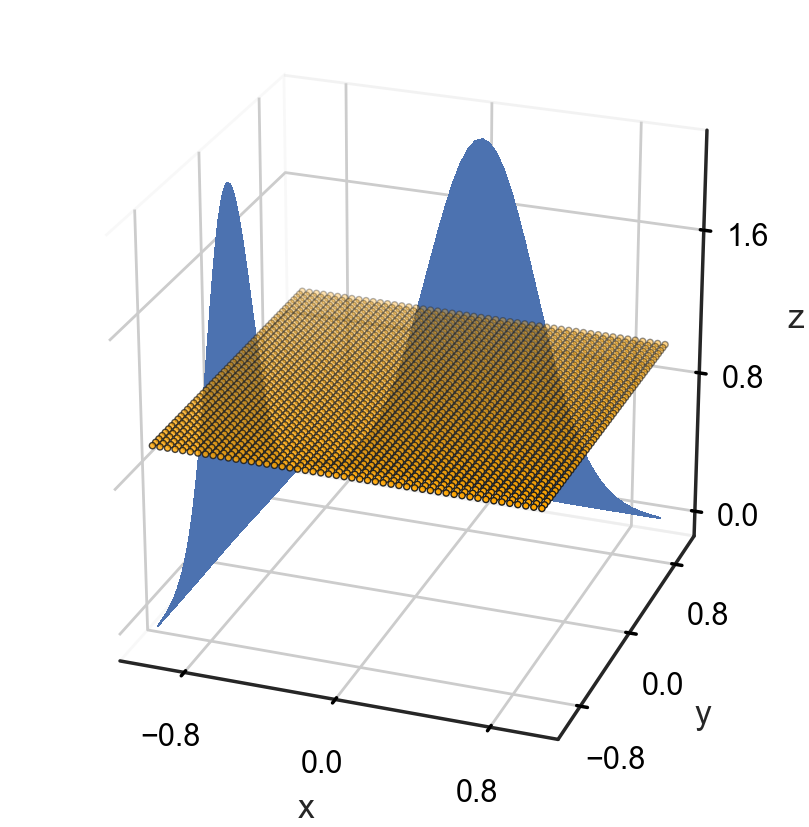

In [16]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.contourf(X, Y, Z, zdir='y', offset=1, levels=1, colors='b')
ax.contourf(X, Y, Z, zdir='x', offset=-1, levels=1, colors='b')
ax.scatter(*query_points.T, fc='orange', ec='k', s=5, lw=0.5)
ax = set_3d_params(ax)
ax.view_init(25, -70);

In [17]:
# check if the orange dots are inside or out of the compliance zone
val = assess_compliance(query_points, points,
                        normals=normals)

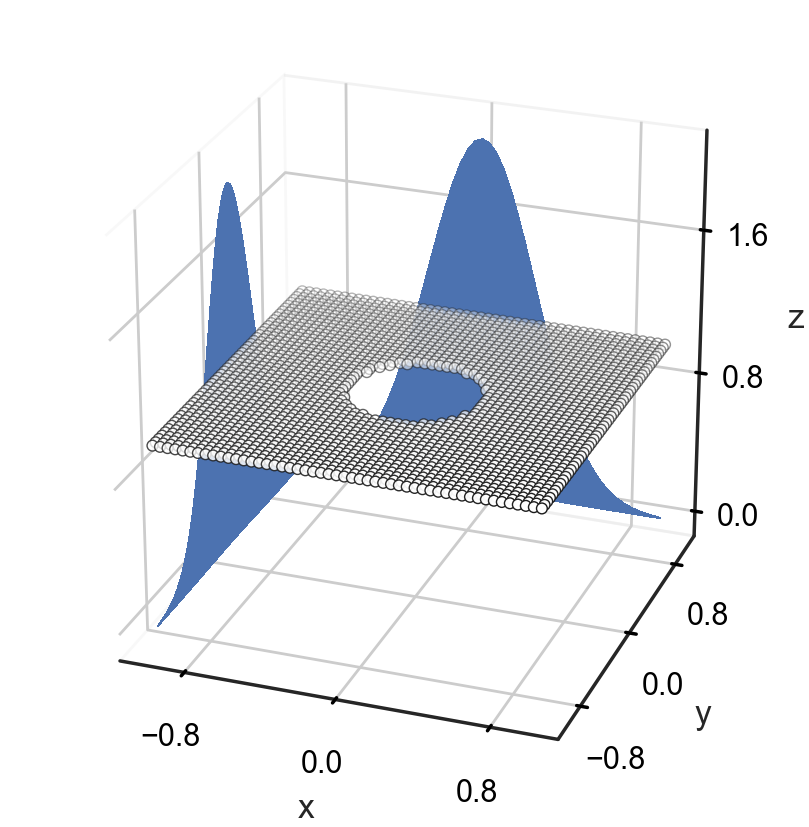

In [18]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.contourf(X, Y, Z, zdir='y', offset=1, levels=1, colors='b')
ax.contourf(X, Y, Z, zdir='x', offset=-1, levels=1, colors='b')
ax.scatter(*query_points[val > 0, ...].T, fc='w', ec='k', s=15, lw=0.5)
ax = set_3d_params(ax)
ax.view_init(25, -70);

In [19]:
# find out the approximate radius where f(x, y) is ~1
idx = np.where(np.isclose(Z, 1, rtol=1e-2, atol=1e-2))
r = np.mean(np.sqrt(X[idx] ** 2 + Y[idx] ** 2))

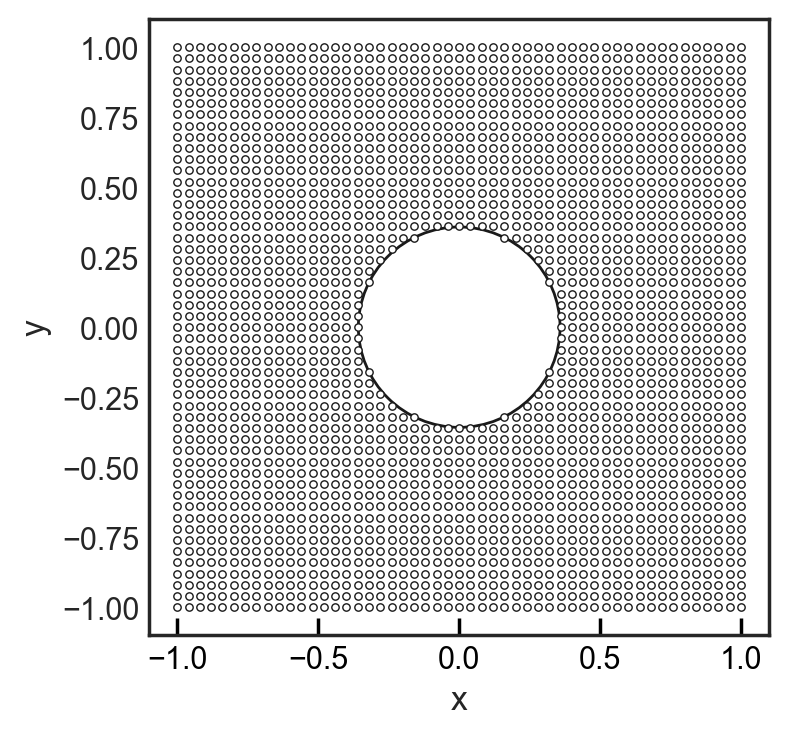

In [20]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
circle = patches.Circle((0, 0), r, fc='none', ec='k')
ax.add_patch(circle)
ax.scatter(*query_points[val > 0, :2].T,
           fc='w', ec='k', s=7, lw=0.5)
ax.set(xlabel='x', ylabel='y');